In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#auto
#plt.ioff()

##### TODO: select the strongest peaks only

peaks = np.load('cxic0415_peaks106.npy')
iX = np.load('cxic0415_iX.npy')
iY = np.load('cxic0415_iY.npy')

cx = 872 # self.parent.cx
cy = 882 # self.parent.cy

photonEnergy = 12.6889 # keV
D = 0.139 # m
pixSize = 110e-6 # m
wavelength = 12.407002 / float(photonEnergy) * 1e-10  # m

cenX = iX[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels
cenY = iY[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels

#strongInd = np.where(cenX > 500) and np.where(cenX < 1100) and np.where(cenY > 500) and np.where(cenY < 1100)
#cenX = cenX[strongInd]
#cenY = cenY[strongInd]

Xd = (cenX - cx) * pixSize # m
Yd = (cenY - cy) * pixSize # m
r = np.sqrt(Xd**2 + Yd**2 + D**2) # m
s = np.array([D/r-1, Xd/r, Yd/r]) / (wavelength) # m^-1

In [267]:
#strongInd = np.where(cenX > 500) and np.where(cenX < 1100) and np.where(cenY > 500) and np.where(cenY < 1100)
strongInd = (np.where(cenX < 700) or np.where(cenX > 900)) or (np.where(cenY < 700) or np.where(cenY > 900))

print(cenX[strongInd], cenY[strongInd])

[604.5 639.5 652.5 666.5 677.5 678.5 679.5 690.5 691.5] [1026.5 1046.5 1094.5 1143.5 1054.5 1099.5 1145.5 1057.5 1102.5]


In [2]:
_,numPeaks = s.shape

#norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
#qPeaks = np.array([x,y,z])/(wavelength*norm)
#s = np.array([D/r-1, Xd/r, Yd/r]) # unitless        

print("s0: ",s[:,0], np.sqrt(np.sum(s[:,0]**2)))
#print(qPeaks)

import matplotlib.pyplot as plt
#plt.plot(y,x,'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#plt.plot(qPeaks[0,:],qPeaks[1,:],'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#from mpl_toolkits.mplot3d import Axes3D
#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#ax.scatter(*s)
#ax.set_aspect('equal')
#plt.show()

#ind = 5
#print(np.sqrt(qPeaks[0,ind]**2+qPeaks[1,ind]**2+(qPeaks[2,ind])**2))

# Generate points on hemisphere
N = 200000
dim = 3

np.random.seed(0)
norm = np.random.normal
normal_deviates = norm(size=(dim, N))
print(normal_deviates, normal_deviates.shape)

radius = np.sqrt((normal_deviates**2).sum(axis=0))
points = normal_deviates/radius
ind = np.where(points[0,:]<=0)
points = points[:,ind]
tx = np.squeeze(points[0,:])
ty = np.squeeze(points[1,:])
tz = np.squeeze(points[2,:])
numSamples = len(tx)

#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#ax.scatter(*points)
#ax.set_aspect('equal')
#plt.show()

def fj(signal, nBins):
    maxSignal = np.max(signal)
    bins = np.linspace(0, maxSignal, nBins)
    binSize = maxSignal/nBins
    digitized = np.digitize(signal, bins)
    ff = np.zeros((nBins,))
    for i in digitized:
        ff[i-1] += 1
    return ff, bins, binSize

_f = np.zeros((numSamples,numPeaks))
numBins = 2800
f = np.zeros((numSamples,numBins))
F = np.zeros((numSamples,int(numBins/2)))
candidate = []
candidateLen = []
candidateLikely = []
threshF = 50
gap = 5
for j in range(numSamples):
    t = np.array([tx[j], ty[j], tz[j]])
    for i in range(numPeaks):
        q = s[:,i] # Bragg spots in reciprocal space
        p = np.abs(np.dot(q, t)) # Bragg spots projected on to vector t
        _f[j,i] = p 
    f[j,:],bins,binSize = fj(_f[j,:],numBins)   
    sp = np.fft.fftshift(abs(np.fft.fft(f[j,:])))
    F[j,:] = sp[int(numBins/2)::]
    if len(np.where(F[j,gap::]>threshF)[0]):
        candidate.append(j)
        print("candidate: ", j)
        #print("t: ", t)
        #print("q: ", q)
        #print("p: ", p)
        #print("binSize: ", binSize)
        ii = np.where(F[j,gap::]>threshF)[0][0]
        print("pos: ", ii+gap)
        likely = F[j,ii+gap]
        print(likely)
        x_real = (ii+gap) / (numBins * binSize)
        print("unit cell basis vector (real-space dimension): ", x_real)
        candidateLen.append(x_real)
        candidateLikely.append(likely)
        fRange = (numBins * binSize) # m^-1
        FbinSize = 1/fRange # m
        Faxis = range(F.shape[1]) * FbinSize * 1e10 # Angstroms
        #plt.subplot(121)
        #plt.plot(bins,f[j,:])
        #plt.subplot(122)
        #plt.plot(Faxis,F[j,:])
        #plt.xlabel('Axis length (A)')
        #plt.xticks(np.array([0,50,100,150,200]))
        #plt.show()
        #break
print(candidate)

s0:  [-3.31031597e+08 -2.58048160e+09  5.09047964e+07] 2602125768.0647187
[[ 1.76405235  0.40015721  0.97873798 ...  0.66781483 -1.02119452
  -0.34537316]
 [ 0.0395099   0.33837761 -0.84218319 ...  1.23838592 -0.12530564
   0.56857042]
 [-1.05173782  0.13980975 -1.09872236 ...  0.55318153  1.62551497
  -0.32702029]] (3, 200000)
candidate:  21
pos:  38
55.73718016932364
unit cell basis vector (real-space dimension):  1.070475401759631e-08
candidate:  57
pos:  8
50.09257923279888
unit cell basis vector (real-space dimension):  3.3445450330899753e-09
candidate:  96
pos:  5
70.92363610815912
unit cell basis vector (real-space dimension):  1.4861915966929982e-09
candidate:  106
pos:  115
51.22485106008424
unit cell basis vector (real-space dimension):  1.822698279436399e-08
candidate:  129
pos:  5
65.021428424568
unit cell basis vector (real-space dimension):  2.1101605208486455e-09
candidate:  136
pos:  5
56.95845687112574
unit cell basis vector (real-space dimension):  1.3773862158752763e

candidate:  2406
pos:  69
50.05279328109052
unit cell basis vector (real-space dimension):  1.1056034000655103e-08
candidate:  2408
pos:  5
55.077930858829525
unit cell basis vector (real-space dimension):  3.3452139240971446e-09
candidate:  2440
pos:  6
53.833032173900975
unit cell basis vector (real-space dimension):  3.976209227241491e-09
candidate:  2454
pos:  205
51.43305758643239
unit cell basis vector (real-space dimension):  3.3965751426664403e-08
candidate:  2458
pos:  24
56.953882156268136
unit cell basis vector (real-space dimension):  5.707682070637317e-09
candidate:  2465
pos:  45
69.05070431462684
unit cell basis vector (real-space dimension):  1.0049913706644153e-08
candidate:  2504
pos:  5
57.064129915366024
unit cell basis vector (real-space dimension):  1.789668865854578e-09
candidate:  2535
pos:  5
55.77846689847128
unit cell basis vector (real-space dimension):  1.3524133166049315e-09
candidate:  2591
pos:  5
68.73065697106092
unit cell basis vector (real-space dime

candidate:  4412
pos:  5
56.83845961242458
unit cell basis vector (real-space dimension):  2.7583692618640985e-09
candidate:  4431
pos:  25
52.24592483868599
unit cell basis vector (real-space dimension):  5.760260620713908e-09
candidate:  4444
pos:  5
54.054898407171
unit cell basis vector (real-space dimension):  2.7898922528524786e-09
candidate:  4488
pos:  69
50.658398344698064
unit cell basis vector (real-space dimension):  1.2742631787569928e-08
candidate:  4505
pos:  5
56.36980064988966
unit cell basis vector (real-space dimension):  1.9636081159457987e-09
candidate:  4590
pos:  30
51.48316829298367
unit cell basis vector (real-space dimension):  7.209389494432788e-09
candidate:  4671
pos:  5
55.45502277805745
unit cell basis vector (real-space dimension):  1.9245464495092536e-09
candidate:  4713
pos:  72
52.45107201502767
unit cell basis vector (real-space dimension):  1.7249943016635496e-08
candidate:  4793
pos:  51
52.013472619040726
unit cell basis vector (real-space dimensi

candidate:  7103
pos:  5
67.66603219574726
unit cell basis vector (real-space dimension):  1.9302690277552008e-09
candidate:  7181
pos:  19
56.36739972818044
unit cell basis vector (real-space dimension):  3.786576472052883e-09
candidate:  7208
pos:  5
53.048933534784126
unit cell basis vector (real-space dimension):  1.33865722511543e-09
candidate:  7209
pos:  197
59.419235495500175
unit cell basis vector (real-space dimension):  3.570660239352165e-08
candidate:  7231
pos:  25
72.71225789162246
unit cell basis vector (real-space dimension):  5.775484270398711e-09
candidate:  7336
pos:  89
67.4455169645112
unit cell basis vector (real-space dimension):  1.526692618978431e-08
candidate:  7337
pos:  68
73.82808806369779
unit cell basis vector (real-space dimension):  1.5037778376433433e-08
candidate:  7412
pos:  23
52.922374509170865
unit cell basis vector (real-space dimension):  5.253968764880873e-09
candidate:  7432
pos:  5
68.78436893059862
unit cell basis vector (real-space dimensio

candidate:  9603
pos:  5
61.36473692622559
unit cell basis vector (real-space dimension):  2.123105237115871e-09
candidate:  9620
pos:  5
68.99099145693117
unit cell basis vector (real-space dimension):  1.4982990503122348e-09
candidate:  9625
pos:  91
70.45886811610197
unit cell basis vector (real-space dimension):  1.4220980679232409e-08
candidate:  9637
pos:  182
58.87965399977574
unit cell basis vector (real-space dimension):  3.2197342652581715e-08
candidate:  9668
pos:  5
68.21502185285465
unit cell basis vector (real-space dimension):  1.4592747158277945e-09
candidate:  9723
pos:  5
54.05322350464265
unit cell basis vector (real-space dimension):  1.8483213676991555e-09
candidate:  9743
pos:  39
57.47040904360454
unit cell basis vector (real-space dimension):  1.1280609772216982e-08
candidate:  9792
pos:  24
68.39549690203302
unit cell basis vector (real-space dimension):  5.4246234567452465e-09
candidate:  9841
pos:  76
51.5005361778837
unit cell basis vector (real-space dimens

candidate:  12073
pos:  91
87.66462560094264
unit cell basis vector (real-space dimension):  2.5561591393922204e-08
candidate:  12101
pos:  138
54.113594703645916
unit cell basis vector (real-space dimension):  2.261669639664556e-08
candidate:  12102
pos:  5
68.93067060669284
unit cell basis vector (real-space dimension):  1.4943572970039342e-09
candidate:  12190
pos:  39
50.003603533084714
unit cell basis vector (real-space dimension):  8.959398229420888e-09
candidate:  12198
pos:  86
55.72781389416819
unit cell basis vector (real-space dimension):  1.6431654083571788e-08
candidate:  12210
pos:  23
52.718364625226144
unit cell basis vector (real-space dimension):  5.790993755518073e-09
candidate:  12234
pos:  5
53.40919696637613
unit cell basis vector (real-space dimension):  1.370445667196012e-09
candidate:  12270
pos:  39
63.01324351830176
unit cell basis vector (real-space dimension):  1.1711022177901485e-08
candidate:  12271
pos:  5
56.274771820609345
unit cell basis vector (real-

candidate:  14482
pos:  5
66.3718873435325
unit cell basis vector (real-space dimension):  3.24244779825709e-09
candidate:  14492
pos:  25
51.243556396074005
unit cell basis vector (real-space dimension):  5.889360275239299e-09
candidate:  14495
pos:  5
60.18258401377727
unit cell basis vector (real-space dimension):  1.3877133314163225e-09
candidate:  14543
pos:  52
55.66850832819898
unit cell basis vector (real-space dimension):  1.0405005006846479e-08
candidate:  14573
pos:  5
50.84122214172072
unit cell basis vector (real-space dimension):  1.3944647163641515e-09
candidate:  14591
pos:  5
67.03388276164135
unit cell basis vector (real-space dimension):  1.7052195977479205e-09
candidate:  14599
pos:  5
52.21001032977723
unit cell basis vector (real-space dimension):  1.3713381161596517e-09
candidate:  14641
pos:  5
79.73198037668894
unit cell basis vector (real-space dimension):  1.598452614156057e-09
candidate:  14673
pos:  131
70.84190641144326
unit cell basis vector (real-space d

candidate:  16687
pos:  25
55.93291534466508
unit cell basis vector (real-space dimension):  5.841512648560456e-09
candidate:  16706
pos:  68
55.52357605128018
unit cell basis vector (real-space dimension):  1.144987058507461e-08
candidate:  16740
pos:  16
57.380637250689546
unit cell basis vector (real-space dimension):  5.754447621386385e-09
candidate:  16778
pos:  5
64.64459020165216
unit cell basis vector (real-space dimension):  1.7159819811098949e-09
candidate:  16838
pos:  6
53.895058342081725
unit cell basis vector (real-space dimension):  3.4648932718568177e-09
candidate:  16842
pos:  127
50.704603351651244
unit cell basis vector (real-space dimension):  2.591033301225021e-08
candidate:  16896
pos:  5
58.466194896013874
unit cell basis vector (real-space dimension):  2.9486944933583603e-09
candidate:  16939
pos:  30
51.42149646121157
unit cell basis vector (real-space dimension):  7.082972037404309e-09
candidate:  16960
pos:  5
61.76817784168688
unit cell basis vector (real-sp

candidate:  18951
pos:  24
51.1327662000555
unit cell basis vector (real-space dimension):  5.84367038733451e-09
candidate:  18971
pos:  47
69.09840041129458
unit cell basis vector (real-space dimension):  1.0030031359530853e-08
candidate:  19001
pos:  23
65.929096559184
unit cell basis vector (real-space dimension):  5.16348270001156e-09
candidate:  19003
pos:  5
62.658395922840576
unit cell basis vector (real-space dimension):  1.6691911077267924e-09
candidate:  19010
pos:  110
97.15969887671037
unit cell basis vector (real-space dimension):  2.0196118787206933e-08
candidate:  19021
pos:  50
51.324507926869735
unit cell basis vector (real-space dimension):  9.907771944727623e-09
candidate:  19030
pos:  5
60.2616929724049
unit cell basis vector (real-space dimension):  2.0985597120145438e-09
candidate:  19066
pos:  5
62.85352646306907
unit cell basis vector (real-space dimension):  1.8118642871353179e-09
candidate:  19091
pos:  27
52.48246918648363
unit cell basis vector (real-space d

candidate:  20718
pos:  25
83.31372250916763
unit cell basis vector (real-space dimension):  5.7921471717992635e-09
candidate:  20726
pos:  5
66.81805848687213
unit cell basis vector (real-space dimension):  2.9995386750772472e-09
candidate:  20784
pos:  5
50.75426899273802
unit cell basis vector (real-space dimension):  3.073867089410918e-09
candidate:  20797
pos:  5
53.275060550083936
unit cell basis vector (real-space dimension):  3.476880652521555e-09
candidate:  20808
pos:  5
63.89724484044692
unit cell basis vector (real-space dimension):  1.8227953313473468e-09
candidate:  20811
pos:  68
61.592052757391095
unit cell basis vector (real-space dimension):  1.510579618684806e-08
candidate:  20836
pos:  5
60.19694454028195
unit cell basis vector (real-space dimension):  1.6229666645177568e-09
candidate:  20872
pos:  5
80.73253204858005
unit cell basis vector (real-space dimension):  1.5716773707435326e-09
candidate:  20920
pos:  5
54.59728525032734
unit cell basis vector (real-space 

candidate:  22588
pos:  90
55.32988070394326
unit cell basis vector (real-space dimension):  2.5566949547533853e-08
candidate:  22645
pos:  21
51.49031632850779
unit cell basis vector (real-space dimension):  4.838413191933005e-09
candidate:  22707
pos:  5
51.08736497441759
unit cell basis vector (real-space dimension):  1.958716698605377e-09
candidate:  22819
pos:  5
74.02823853000508
unit cell basis vector (real-space dimension):  2.005880874001015e-09
candidate:  22892
pos:  66
67.27557430652811
unit cell basis vector (real-space dimension):  2.0289574548425648e-08
candidate:  22900
pos:  50
50.02348915522821
unit cell basis vector (real-space dimension):  9.886651341989604e-09
candidate:  22933
pos:  52
51.2700728063412
unit cell basis vector (real-space dimension):  1.0417373892551993e-08
candidate:  23033
pos:  5
66.47767636532093
unit cell basis vector (real-space dimension):  1.4568059384242542e-09
candidate:  23043
pos:  22
66.43333633438125
unit cell basis vector (real-space 

candidate:  24796
pos:  5
74.97412116859844
unit cell basis vector (real-space dimension):  1.6628824435379996e-09
candidate:  24822
pos:  24
55.73034085161674
unit cell basis vector (real-space dimension):  5.642945559497588e-09
candidate:  24849
pos:  129
63.778990914558655
unit cell basis vector (real-space dimension):  2.5529867193647066e-08
candidate:  24856
pos:  5
52.139432097620535
unit cell basis vector (real-space dimension):  1.4691192177587972e-09
candidate:  24881
pos:  5
54.82229861211414
unit cell basis vector (real-space dimension):  3.2107186956006972e-09
candidate:  24885
pos:  5
54.3782674355998
unit cell basis vector (real-space dimension):  2.9071067445572518e-09
candidate:  24917
pos:  5
50.163950853614544
unit cell basis vector (real-space dimension):  2.2514300044815996e-09
candidate:  24924
pos:  5
72.91206901379003
unit cell basis vector (real-space dimension):  1.7210405032211609e-09
candidate:  24992
pos:  5
53.646061498042954
unit cell basis vector (real-sp

candidate:  27369
pos:  25
106.3789233530333
unit cell basis vector (real-space dimension):  5.784756939956008e-09
candidate:  27384
pos:  8
55.049874337549554
unit cell basis vector (real-space dimension):  3.1664305295622944e-09
candidate:  27424
pos:  5
79.66080504226152
unit cell basis vector (real-space dimension):  1.5505745536721674e-09
candidate:  27464
pos:  5
64.98037250492584
unit cell basis vector (real-space dimension):  1.6141996382061533e-09
candidate:  27472
pos:  5
67.67321242731056
unit cell basis vector (real-space dimension):  1.5423622738859016e-09
candidate:  27540
pos:  6
51.21584071713514
unit cell basis vector (real-space dimension):  3.899226677674905e-09
candidate:  27541
pos:  5
68.98736879108512
unit cell basis vector (real-space dimension):  1.5339932796071479e-09
candidate:  27558
pos:  5
66.45743585514774
unit cell basis vector (real-space dimension):  1.5887891544279768e-09
candidate:  27602
pos:  154
53.08214778281822
unit cell basis vector (real-space

candidate:  29538
pos:  67
73.08056467194756
unit cell basis vector (real-space dimension):  1.1404616989791106e-08
candidate:  29550
pos:  5
67.89073621364138
unit cell basis vector (real-space dimension):  1.5446471738412816e-09
candidate:  29554
pos:  5
63.10624876614854
unit cell basis vector (real-space dimension):  1.4286302305485544e-09
candidate:  29575
pos:  38
57.281945475783964
unit cell basis vector (real-space dimension):  9.56200695164699e-09
candidate:  29624
pos:  5
65.27977672231509
unit cell basis vector (real-space dimension):  1.685031744795431e-09
candidate:  29655
pos:  86
60.74306415243707
unit cell basis vector (real-space dimension):  1.8049177828895092e-08
candidate:  29750
pos:  5
52.59360879913613
unit cell basis vector (real-space dimension):  1.894647069288351e-09
candidate:  29791
pos:  96
52.39512099286714
unit cell basis vector (real-space dimension):  2.087013021924049e-08
candidate:  29829
pos:  68
79.58772848018376
unit cell basis vector (real-space 

candidate:  32185
pos:  65
59.32695870053851
unit cell basis vector (real-space dimension):  1.1222690754692318e-08
candidate:  32187
pos:  5
53.23527608329037
unit cell basis vector (real-space dimension):  3.3341092375042457e-09
candidate:  32218
pos:  5
69.80220204505007
unit cell basis vector (real-space dimension):  2.0631716951980264e-09
candidate:  32297
pos:  39
54.378527972826916
unit cell basis vector (real-space dimension):  1.1322303830219535e-08
candidate:  32318
pos:  41
50.15444290548532
unit cell basis vector (real-space dimension):  1.2292901874878258e-08
candidate:  32356
pos:  44
50.270772298029335
unit cell basis vector (real-space dimension):  9.904733381390414e-09
candidate:  32390
pos:  25
135.32005267276588
unit cell basis vector (real-space dimension):  5.814134878101498e-09
candidate:  32407
pos:  5
51.917405653851546
unit cell basis vector (real-space dimension):  1.400163717836986e-09
candidate:  32420
pos:  5
56.099253528733605
unit cell basis vector (real-

candidate:  33930
pos:  23
53.82820070440906
unit cell basis vector (real-space dimension):  5.717262951304584e-09
candidate:  33995
pos:  13
50.995392545751194
unit cell basis vector (real-space dimension):  5.226415986685887e-09
candidate:  34006
pos:  5
68.49982694292277
unit cell basis vector (real-space dimension):  1.4925380763895595e-09
candidate:  34032
pos:  25
65.07347927023685
unit cell basis vector (real-space dimension):  5.774092945357475e-09
candidate:  34046
pos:  93
57.82593932618431
unit cell basis vector (real-space dimension):  1.4714199071036014e-08
candidate:  34144
pos:  111
55.36396464656227
unit cell basis vector (real-space dimension):  1.9932871555415848e-08
candidate:  34146
pos:  24
68.83487955505906
unit cell basis vector (real-space dimension):  5.641462171954717e-09
candidate:  34222
pos:  38
63.53898629081808
unit cell basis vector (real-space dimension):  1.1646164907735175e-08
candidate:  34246
pos:  53
52.14930096890221
unit cell basis vector (real-s

candidate:  36321
pos:  44
60.35845670818214
unit cell basis vector (real-space dimension):  1.0025465649122203e-08
candidate:  36329
pos:  5
59.929046581010596
unit cell basis vector (real-space dimension):  1.4116664707331183e-09
candidate:  36359
pos:  41
77.94236875145492
unit cell basis vector (real-space dimension):  1.4156420417669153e-08
candidate:  36368
pos:  5
53.280194490331226
unit cell basis vector (real-space dimension):  1.798736165236417e-09
candidate:  36369
pos:  5
61.902836530665844
unit cell basis vector (real-space dimension):  1.8971207242954923e-09
candidate:  36379
pos:  5
69.89443545515263
unit cell basis vector (real-space dimension):  1.740652451343375e-09
candidate:  36392
pos:  7
52.443931865650875
unit cell basis vector (real-space dimension):  2.799321307258237e-09
candidate:  36456
pos:  13
50.55332831669114
unit cell basis vector (real-space dimension):  4.9056960851793124e-09
candidate:  36506
pos:  5
63.90128021868322
unit cell basis vector (real-spa

candidate:  38824
pos:  5
58.10510820959514
unit cell basis vector (real-space dimension):  1.3904646942204405e-09
candidate:  38836
pos:  5
66.3614672319661
unit cell basis vector (real-space dimension):  1.6269318133436103e-09
candidate:  38858
pos:  67
54.09250180272772
unit cell basis vector (real-space dimension):  1.4836640233203253e-08
candidate:  38883
pos:  5
66.99126443684648
unit cell basis vector (real-space dimension):  1.6272251458526635e-09
candidate:  38911
pos:  6
50.9931259362317
unit cell basis vector (real-space dimension):  3.9118173574240025e-09
candidate:  38953
pos:  45
56.07206533843892
unit cell basis vector (real-space dimension):  1.1022297508549568e-08
candidate:  38975
pos:  5
68.32130286064316
unit cell basis vector (real-space dimension):  1.516118715239119e-09
candidate:  39013
pos:  5
52.64123107215462
unit cell basis vector (real-space dimension):  1.896884526971861e-09
candidate:  39129
pos:  24
56.40728834730822
unit cell basis vector (real-space di

candidate:  40850
pos:  5
56.20388875130028
unit cell basis vector (real-space dimension):  1.8526642476279612e-09
candidate:  40875
pos:  40
51.96551117227907
unit cell basis vector (real-space dimension):  1.1932043700644352e-08
candidate:  40912
pos:  11
50.113029929365986
unit cell basis vector (real-space dimension):  2.480306852554414e-09
candidate:  40916
pos:  5
55.64409269913422
unit cell basis vector (real-space dimension):  3.240589596002869e-09
candidate:  40969
pos:  5
67.1436364444729
unit cell basis vector (real-space dimension):  1.7910280295231034e-09
candidate:  41011
pos:  5
50.68201998377442
unit cell basis vector (real-space dimension):  2.102074722397141e-09
candidate:  41057
pos:  48
52.32355158741293
unit cell basis vector (real-space dimension):  1.1569351865789313e-08
candidate:  41104
pos:  68
60.10343318608021
unit cell basis vector (real-space dimension):  1.1302252728164256e-08
candidate:  41110
pos:  5
66.53749127003019
unit cell basis vector (real-space 

candidate:  43032
pos:  25
101.80409194012366
unit cell basis vector (real-space dimension):  5.809997694696743e-09
candidate:  43084
pos:  5
75.64066500454491
unit cell basis vector (real-space dimension):  1.5470307894805442e-09
candidate:  43162
pos:  52
50.235571265065836
unit cell basis vector (real-space dimension):  1.001030478924948e-08
candidate:  43185
pos:  73
53.598769337387495
unit cell basis vector (real-space dimension):  1.3686131113926267e-08
candidate:  43247
pos:  5
54.796986628351945
unit cell basis vector (real-space dimension):  2.7302013083042485e-09
candidate:  43252
pos:  5
63.11516001050061
unit cell basis vector (real-space dimension):  1.5226945842603257e-09
candidate:  43286
pos:  5
70.15616599300358
unit cell basis vector (real-space dimension):  1.4653662916838046e-09
candidate:  43324
pos:  5
51.910782339306934
unit cell basis vector (real-space dimension):  1.3369666954469278e-09
candidate:  43385
pos:  129
60.606011668456404
unit cell basis vector (rea

candidate:  45600
pos:  11
50.445463268689394
unit cell basis vector (real-space dimension):  2.481704734998416e-09
candidate:  45619
pos:  5
68.32943037590877
unit cell basis vector (real-space dimension):  1.6629757878704054e-09
candidate:  45686
pos:  155
83.52324998903633
unit cell basis vector (real-space dimension):  2.6661566771261034e-08
candidate:  45688
pos:  13
50.386855198312794
unit cell basis vector (real-space dimension):  5.187902077242109e-09
candidate:  45717
pos:  5
53.079970060015015
unit cell basis vector (real-space dimension):  2.6355014227541656e-09
candidate:  45723
pos:  5
66.77193031419618
unit cell basis vector (real-space dimension):  3.191033153365649e-09
candidate:  45752
pos:  38
51.83019987712012
unit cell basis vector (real-space dimension):  1.0725667352292794e-08
candidate:  45758
pos:  38
53.06376074561372
unit cell basis vector (real-space dimension):  9.36137510894086e-09
candidate:  45782
pos:  5
63.15452351816854
unit cell basis vector (real-spa

candidate:  47566
pos:  5
56.50286029993231
unit cell basis vector (real-space dimension):  1.4997052460777843e-09
candidate:  47571
pos:  24
67.62317957136727
unit cell basis vector (real-space dimension):  5.659817540870216e-09
candidate:  47578
pos:  68
59.94627542101765
unit cell basis vector (real-space dimension):  1.1303565340462829e-08
candidate:  47584
pos:  5
63.66113699499151
unit cell basis vector (real-space dimension):  1.7263859824948927e-09
candidate:  47693
pos:  136
58.808954761076905
unit cell basis vector (real-space dimension):  2.234422465539931e-08
candidate:  47700
pos:  25
63.19078230219018
unit cell basis vector (real-space dimension):  5.774524274289853e-09
candidate:  47712
pos:  48
59.83468193567981
unit cell basis vector (real-space dimension):  1.1170978874518482e-08
candidate:  47713
pos:  7
51.35362046567361
unit cell basis vector (real-space dimension):  2.724640705777273e-09
candidate:  47751
pos:  67
86.69642671711074
unit cell basis vector (real-spa

candidate:  49721
pos:  19
56.568542030099294
unit cell basis vector (real-space dimension):  3.7628537289483395e-09
candidate:  49773
pos:  44
50.71999687551763
unit cell basis vector (real-space dimension):  1.1022439593043956e-08
candidate:  49776
pos:  5
52.371927371248375
unit cell basis vector (real-space dimension):  2.6581504222608494e-09
candidate:  49884
pos:  5
79.63062350993904
unit cell basis vector (real-space dimension):  1.5592770549875412e-09
candidate:  49937
pos:  46
57.29365023547828
unit cell basis vector (real-space dimension):  1.1385794606150547e-08
candidate:  49998
pos:  5
74.36967027684776
unit cell basis vector (real-space dimension):  1.9810285884388515e-09
candidate:  50008
pos:  64
62.9136631869661
unit cell basis vector (real-space dimension):  1.5125342353843955e-08
candidate:  50029
pos:  5
62.132050361955635
unit cell basis vector (real-space dimension):  1.600433375097477e-09
candidate:  50047
pos:  5
68.79229099347512
unit cell basis vector (real-sp

candidate:  52342
pos:  78
81.69519327800825
unit cell basis vector (real-space dimension):  2.6813798907803587e-08
candidate:  52351
pos:  5
51.123518735716054
unit cell basis vector (real-space dimension):  1.3656841843447866e-09
candidate:  52359
pos:  46
73.87032501140074
unit cell basis vector (real-space dimension):  9.83112309282709e-09
candidate:  52379
pos:  60
51.021359192805804
unit cell basis vector (real-space dimension):  1.4584696006398348e-08
candidate:  52394
pos:  5
51.92205280516774
unit cell basis vector (real-space dimension):  1.3448697688513742e-09
candidate:  52466
pos:  5
65.83350518741811
unit cell basis vector (real-space dimension):  1.7528508015619437e-09
candidate:  52486
pos:  5
65.12758053656714
unit cell basis vector (real-space dimension):  1.5982404124156234e-09
candidate:  52523
pos:  5
52.00520339067668
unit cell basis vector (real-space dimension):  1.8690890394647526e-09
candidate:  52543
pos:  13
61.22761436980786
unit cell basis vector (real-spa

candidate:  54397
pos:  19
51.42780321315644
unit cell basis vector (real-space dimension):  3.74266198341718e-09
candidate:  54412
pos:  222
50.16804617279739
unit cell basis vector (real-space dimension):  3.852180747882557e-08
candidate:  54431
pos:  45
50.006523487480926
unit cell basis vector (real-space dimension):  1.0413615566337067e-08
candidate:  54440
pos:  5
70.35513668440208
unit cell basis vector (real-space dimension):  1.4667945501711609e-09
candidate:  54467
pos:  63
50.447978244636246
unit cell basis vector (real-space dimension):  1.4830349152096644e-08
candidate:  54468
pos:  5
60.32316449697045
unit cell basis vector (real-space dimension):  1.8904102495030166e-09
candidate:  54491
pos:  5
67.04253563887053
unit cell basis vector (real-space dimension):  1.449832700264469e-09
candidate:  54506
pos:  7
58.37953871726644
unit cell basis vector (real-space dimension):  3.0252572203244533e-09
candidate:  54524
pos:  46
109.49198092444756
unit cell basis vector (real-sp

candidate:  56630
pos:  45
69.61960863680095
unit cell basis vector (real-space dimension):  9.951171892239912e-09
candidate:  56664
pos:  5
64.79036646747382
unit cell basis vector (real-space dimension):  1.9920743396766952e-09
candidate:  56703
pos:  5
56.49156709287141
unit cell basis vector (real-space dimension):  2.126482660548817e-09
candidate:  56704
pos:  5
67.36627641227847
unit cell basis vector (real-space dimension):  1.6144778282914874e-09
candidate:  56766
pos:  23
52.293379610742825
unit cell basis vector (real-space dimension):  5.7020150034065806e-09
candidate:  56805
pos:  5
50.99374747479691
unit cell basis vector (real-space dimension):  1.8843860378778955e-09
candidate:  56839
pos:  5
62.276043721169685
unit cell basis vector (real-space dimension):  2.1343176164196044e-09
candidate:  56858
pos:  45
55.28627400950113
unit cell basis vector (real-space dimension):  1.0973897365033955e-08
candidate:  56937
pos:  45
50.28551874877508
unit cell basis vector (real-spa

candidate:  59367
pos:  5
57.009815097288445
unit cell basis vector (real-space dimension):  2.1841113357582724e-09
candidate:  59482
pos:  66
89.07007327914532
unit cell basis vector (real-space dimension):  2.0383468226337604e-08
candidate:  59497
pos:  5
56.01905127999083
unit cell basis vector (real-space dimension):  1.887023089023548e-09
candidate:  59511
pos:  49
78.96806627070738
unit cell basis vector (real-space dimension):  1.1403442250241829e-08
candidate:  59512
pos:  25
69.67017729614524
unit cell basis vector (real-space dimension):  5.8028823228701704e-09
candidate:  59554
pos:  148
58.819208904414666
unit cell basis vector (real-space dimension):  3.150459087581473e-08
candidate:  59655
pos:  5
56.88282837691632
unit cell basis vector (real-space dimension):  2.030695075196087e-09
candidate:  59724
pos:  5
59.03622452102603
unit cell basis vector (real-space dimension):  3.3638463311981386e-09
candidate:  59727
pos:  5
63.605697128781415
unit cell basis vector (real-sp

candidate:  61551
pos:  5
56.84875986645968
unit cell basis vector (real-space dimension):  1.8519274027218488e-09
candidate:  61573
pos:  24
64.86555241845234
unit cell basis vector (real-space dimension):  5.6840762217997024e-09
candidate:  61581
pos:  114
60.758093403461544
unit cell basis vector (real-space dimension):  2.075818358340961e-08
candidate:  61605
pos:  5
50.14641488485253
unit cell basis vector (real-space dimension):  2.191106458654272e-09
candidate:  61697
pos:  43
53.36556103470581
unit cell basis vector (real-space dimension):  1.0372001045677812e-08
candidate:  61782
pos:  19
53.20671848040259
unit cell basis vector (real-space dimension):  3.744265594735179e-09
candidate:  61793
pos:  5
60.77241434377011
unit cell basis vector (real-space dimension):  1.6751600482304301e-09
candidate:  61814
pos:  5
65.56198896659528
unit cell basis vector (real-space dimension):  1.7149555553027566e-09
candidate:  61836
pos:  13
76.96146509482944
unit cell basis vector (real-spa

candidate:  63804
pos:  154
51.54985240308694
unit cell basis vector (real-space dimension):  2.565157890773279e-08
candidate:  63810
pos:  73
55.01684624355928
unit cell basis vector (real-space dimension):  2.0710452318512724e-08
candidate:  63841
pos:  5
79.25784116483447
unit cell basis vector (real-space dimension):  1.5326601253261046e-09
candidate:  63922
pos:  45
54.95695767159644
unit cell basis vector (real-space dimension):  1.1158568736399458e-08
candidate:  64041
pos:  5
55.6570616359495
unit cell basis vector (real-space dimension):  1.5728121017271038e-09
candidate:  64088
pos:  43
52.265782584653095
unit cell basis vector (real-space dimension):  1.0277695352689188e-08
candidate:  64130
pos:  5
50.04098977908169
unit cell basis vector (real-space dimension):  3.538502271842866e-09
candidate:  64159
pos:  43
55.23877699972962
unit cell basis vector (real-space dimension):  9.58721028498842e-09
candidate:  64162
pos:  116
54.496251729233165
unit cell basis vector (real-sp

candidate:  65962
pos:  5
54.30555251004719
unit cell basis vector (real-space dimension):  1.7575500351171059e-09
candidate:  66006
pos:  5
67.90203624158595
unit cell basis vector (real-space dimension):  1.479608387889917e-09
candidate:  66018
pos:  5
51.942335752064054
unit cell basis vector (real-space dimension):  1.3694912145411877e-09
candidate:  66023
pos:  38
52.14247764798817
unit cell basis vector (real-space dimension):  1.0681986099871544e-08
candidate:  66037
pos:  5
52.076436653014646
unit cell basis vector (real-space dimension):  2.6474462644743948e-09
candidate:  66134
pos:  5
51.86749421104636
unit cell basis vector (real-space dimension):  2.6414489172988896e-09
candidate:  66246
pos:  54
66.47533896911905
unit cell basis vector (real-space dimension):  1.8475900841883775e-08
candidate:  66260
pos:  5
60.04059644739165
unit cell basis vector (real-space dimension):  1.7805726213394024e-09
candidate:  66261
pos:  27
50.26050239484724
unit cell basis vector (real-spa

candidate:  68295
pos:  44
100.22866414499784
unit cell basis vector (real-space dimension):  1.5454976809450017e-08
candidate:  68326
pos:  5
57.49972581235934
unit cell basis vector (real-space dimension):  1.770065000213956e-09
candidate:  68330
pos:  52
55.242220883199955
unit cell basis vector (real-space dimension):  1.0379677804222293e-08
candidate:  68340
pos:  112
56.271753244497205
unit cell basis vector (real-space dimension):  2.22889913986888e-08
candidate:  68341
pos:  5
54.98750007134454
unit cell basis vector (real-space dimension):  1.3677848420732704e-09
candidate:  68398
pos:  5
68.94491698666937
unit cell basis vector (real-space dimension):  1.5166216624728315e-09
candidate:  68401
pos:  25
124.28784110800764
unit cell basis vector (real-space dimension):  5.817810284319274e-09
candidate:  68410
pos:  5
77.6021138325389
unit cell basis vector (real-space dimension):  1.669313945314882e-09
candidate:  68411
pos:  5
50.039015981558386
unit cell basis vector (real-spa

candidate:  70391
pos:  64
50.10905262302539
unit cell basis vector (real-space dimension):  2.020921963741752e-08
candidate:  70400
pos:  44
72.11526348709705
unit cell basis vector (real-space dimension):  1.5582441243906047e-08
candidate:  70404
pos:  80
53.22561253324305
unit cell basis vector (real-space dimension):  2.3424900057667566e-08
candidate:  70426
pos:  5
63.98653758685968
unit cell basis vector (real-space dimension):  2.1082989159100584e-09
candidate:  70440
pos:  5
54.40422183179275
unit cell basis vector (real-space dimension):  3.2572240513057514e-09
candidate:  70456
pos:  5
67.21139647435832
unit cell basis vector (real-space dimension):  1.51259201583348e-09
candidate:  70465
pos:  13
57.29980000255374
unit cell basis vector (real-space dimension):  4.872711165856172e-09
candidate:  70563
pos:  5
68.60890693503754
unit cell basis vector (real-space dimension):  1.5618780261305243e-09
candidate:  70572
pos:  5
71.5969115911902
unit cell basis vector (real-space di

candidate:  72489
pos:  5
53.04565840922211
unit cell basis vector (real-space dimension):  2.5258343809048457e-09
candidate:  72517
pos:  5
51.71903448118893
unit cell basis vector (real-space dimension):  2.1393277379829674e-09
candidate:  72566
pos:  67
65.38135910620967
unit cell basis vector (real-space dimension):  1.1549861081117023e-08
candidate:  72593
pos:  5
51.912919849020746
unit cell basis vector (real-space dimension):  3.2270509299851903e-09
candidate:  72616
pos:  5
64.98557664561996
unit cell basis vector (real-space dimension):  1.7601052705457885e-09
candidate:  72646
pos:  7
55.47510920507963
unit cell basis vector (real-space dimension):  2.808426095440797e-09
candidate:  72678
pos:  26
55.59065682555877
unit cell basis vector (real-space dimension):  5.979539682601498e-09
candidate:  72749
pos:  19
54.02569177882232
unit cell basis vector (real-space dimension):  3.797056017041284e-09
candidate:  72766
pos:  46
52.669742196333765
unit cell basis vector (real-spac

candidate:  74924
pos:  45
54.41701793412054
unit cell basis vector (real-space dimension):  9.801363656692696e-09
candidate:  74977
pos:  69
55.94803242916633
unit cell basis vector (real-space dimension):  1.1321015759272946e-08
candidate:  75035
pos:  5
58.828748390706004
unit cell basis vector (real-space dimension):  2.026875596583078e-09
candidate:  75036
pos:  7
50.174774261549615
unit cell basis vector (real-space dimension):  2.70317348849466e-09
candidate:  75094
pos:  5
67.4518012368374
unit cell basis vector (real-space dimension):  1.6159096107452198e-09
candidate:  75193
pos:  25
90.53443359212264
unit cell basis vector (real-space dimension):  5.864903536789753e-09
candidate:  75227
pos:  5
60.26081379882865
unit cell basis vector (real-space dimension):  1.4678425687085972e-09
candidate:  75249
pos:  5
54.39985058275977
unit cell basis vector (real-space dimension):  2.9505417363373095e-09
candidate:  75259
pos:  5
68.82540763326458
unit cell basis vector (real-space di

candidate:  77310
pos:  45
55.44257294364069
unit cell basis vector (real-space dimension):  1.0611389546785382e-08
candidate:  77373
pos:  15
53.11625651792389
unit cell basis vector (real-space dimension):  5.320304784703103e-09
candidate:  77416
pos:  64
56.18001719053281
unit cell basis vector (real-space dimension):  1.2763610889688804e-08
candidate:  77455
pos:  5
61.15145023453693
unit cell basis vector (real-space dimension):  1.6096703239143414e-09
candidate:  77458
pos:  5
56.52565683431062
unit cell basis vector (real-space dimension):  2.9302847421617194e-09
candidate:  77464
pos:  5
55.564320399406945
unit cell basis vector (real-space dimension):  1.380528161506458e-09
candidate:  77499
pos:  23
54.672634421092496
unit cell basis vector (real-space dimension):  5.1293022496097796e-09
candidate:  77504
pos:  13
53.69400725111306
unit cell basis vector (real-space dimension):  4.724504709778167e-09
candidate:  77516
pos:  5
62.258951913899836
unit cell basis vector (real-sp

candidate:  79549
pos:  23
52.00360965860977
unit cell basis vector (real-space dimension):  5.741300418170234e-09
candidate:  79581
pos:  5
63.57073554197633
unit cell basis vector (real-space dimension):  1.451277446519864e-09
candidate:  79682
pos:  40
55.17618219687059
unit cell basis vector (real-space dimension):  9.342525747212674e-09
candidate:  79703
pos:  24
68.64024747537057
unit cell basis vector (real-space dimension):  5.6501730153858165e-09
candidate:  79740
pos:  5
60.883463299970934
unit cell basis vector (real-space dimension):  1.415902187349562e-09
candidate:  79770
pos:  136
55.67355952410701
unit cell basis vector (real-space dimension):  2.2568235502586923e-08
candidate:  79795
pos:  131
79.3706872030862
unit cell basis vector (real-space dimension):  2.5462695662333006e-08
candidate:  79802
pos:  66
79.04582105127726
unit cell basis vector (real-space dimension):  1.158093401263271e-08
candidate:  79808
pos:  69
52.03153018272971
unit cell basis vector (real-spa

candidate:  82214
pos:  5
64.31975079144713
unit cell basis vector (real-space dimension):  1.7043661932496466e-09
candidate:  82224
pos:  5
55.1446446861725
unit cell basis vector (real-space dimension):  1.5317710399215048e-09
candidate:  82238
pos:  208
57.09727966513858
unit cell basis vector (real-space dimension):  4.0596790285383104e-08
candidate:  82249
pos:  5
68.34671022019926
unit cell basis vector (real-space dimension):  1.7449792449584488e-09
candidate:  82318
pos:  23
55.037509897487595
unit cell basis vector (real-space dimension):  5.135103826175372e-09
candidate:  82414
pos:  47
100.8842998946995
unit cell basis vector (real-space dimension):  9.955198913193704e-09
candidate:  82448
pos:  138
56.03921496429165
unit cell basis vector (real-space dimension):  2.2622617051547435e-08
candidate:  82451
pos:  5
74.63761181839529
unit cell basis vector (real-space dimension):  1.984287628284605e-09
candidate:  82489
pos:  64
57.746474012565194
unit cell basis vector (real-sp

candidate:  84192
pos:  40
55.59092664572952
unit cell basis vector (real-space dimension):  9.390763918351505e-09
candidate:  84223
pos:  25
67.95771781370927
unit cell basis vector (real-space dimension):  5.8183928469421506e-09
candidate:  84226
pos:  67
81.800215557725
unit cell basis vector (real-space dimension):  1.1443531222145806e-08
candidate:  84261
pos:  25
56.200804453970804
unit cell basis vector (real-space dimension):  5.84520659933016e-09
candidate:  84269
pos:  89
53.26206082043973
unit cell basis vector (real-space dimension):  3.108826739924362e-08
candidate:  84325
pos:  43
65.88965699811351
unit cell basis vector (real-space dimension):  9.60856823613662e-09
candidate:  84326
pos:  109
51.742220466859195
unit cell basis vector (real-space dimension):  2.535850047021762e-08
candidate:  84378
pos:  138
50.713988627815844
unit cell basis vector (real-space dimension):  2.2602458850259756e-08
candidate:  84426
pos:  5
70.42086453416444
unit cell basis vector (real-spa

candidate:  86619
pos:  24
63.75697281611344
unit cell basis vector (real-space dimension):  5.62353669557294e-09
candidate:  86652
pos:  25
60.0708924573605
unit cell basis vector (real-space dimension):  5.7886120445122185e-09
candidate:  86661
pos:  116
51.6201081383069
unit cell basis vector (real-space dimension):  3.299554075436477e-08
candidate:  86674
pos:  7
57.77515804405726
unit cell basis vector (real-space dimension):  2.820516948154763e-09
candidate:  86678
pos:  5
58.54853116008755
unit cell basis vector (real-space dimension):  2.165266070267111e-09
candidate:  86679
pos:  5
51.268651006077924
unit cell basis vector (real-space dimension):  2.2858975007899233e-09
candidate:  86685
pos:  8
50.09074546600412
unit cell basis vector (real-space dimension):  4.62600712968538e-09
candidate:  86741
pos:  5
67.07956699848512
unit cell basis vector (real-space dimension):  1.4602187777961037e-09
candidate:  86745
pos:  5
51.0001147778098
unit cell basis vector (real-space dimens

candidate:  88468
pos:  5
68.38102391551723
unit cell basis vector (real-space dimension):  1.4563619856472653e-09
candidate:  88470
pos:  38
63.57893886602113
unit cell basis vector (real-space dimension):  1.1664833169727701e-08
candidate:  88488
pos:  25
86.67210017875158
unit cell basis vector (real-space dimension):  5.784766750246444e-09
candidate:  88551
pos:  5
60.32722902266624
unit cell basis vector (real-space dimension):  1.4193290618551443e-09
candidate:  88560
pos:  5
71.51496550424157
unit cell basis vector (real-space dimension):  1.8580587588283625e-09
candidate:  88569
pos:  68
67.70569646887427
unit cell basis vector (real-space dimension):  1.5004905898874173e-08
candidate:  88574
pos:  46
51.25814884191191
unit cell basis vector (real-space dimension):  1.1298678050047502e-08
candidate:  88583
pos:  44
51.383016956420555
unit cell basis vector (real-space dimension):  1.5296445187035118e-08
candidate:  88622
pos:  5
56.14636366897125
unit cell basis vector (real-sp

candidate:  90352
pos:  67
52.90970887782165
unit cell basis vector (real-space dimension):  1.4198785360568761e-08
candidate:  90377
pos:  5
66.02361301629934
unit cell basis vector (real-space dimension):  2.928583615043175e-09
candidate:  90396
pos:  5
56.147965303296004
unit cell basis vector (real-space dimension):  2.993517475682802e-09
candidate:  90409
pos:  5
61.83202947537307
unit cell basis vector (real-space dimension):  1.6447078762967755e-09
candidate:  90437
pos:  113
64.29519285450979
unit cell basis vector (real-space dimension):  3.246482918886315e-08
candidate:  90492
pos:  5
57.73759979732562
unit cell basis vector (real-space dimension):  2.7203758454283824e-09
candidate:  90499
pos:  5
53.704235797291595
unit cell basis vector (real-space dimension):  3.6339514588354895e-09
candidate:  90544
pos:  7
60.09796168524764
unit cell basis vector (real-space dimension):  2.9359108632136796e-09
candidate:  90561
pos:  21
50.72681505974766
unit cell basis vector (real-spac

candidate:  92962
pos:  6
54.84090873697935
unit cell basis vector (real-space dimension):  4.08874278484429e-09
candidate:  92965
pos:  43
74.37827020575725
unit cell basis vector (real-space dimension):  9.683480754495123e-09
candidate:  93063
pos:  68
59.90300024480646
unit cell basis vector (real-space dimension):  1.511927829036831e-08
candidate:  93114
pos:  119
53.69345407878036
unit cell basis vector (real-space dimension):  2.2063348366952228e-08
candidate:  93161
pos:  93
51.23294963592542
unit cell basis vector (real-space dimension):  1.4704317299550322e-08
candidate:  93165
pos:  5
61.85968026452682
unit cell basis vector (real-space dimension):  1.5095158138438137e-09
candidate:  93234
pos:  68
69.50267420667994
unit cell basis vector (real-space dimension):  1.4997207767627273e-08
candidate:  93288
pos:  64
58.085835101330794
unit cell basis vector (real-space dimension):  1.5168204046652864e-08
candidate:  93336
pos:  5
61.84189659638532
unit cell basis vector (real-spa

candidate:  95233
pos:  5
50.8263214669292
unit cell basis vector (real-space dimension):  1.3266882049610624e-09
candidate:  95251
pos:  54
58.558233565506484
unit cell basis vector (real-space dimension):  1.8488365111854688e-08
candidate:  95283
pos:  5
65.6009517235859
unit cell basis vector (real-space dimension):  3.0316023912517863e-09
candidate:  95290
pos:  5
56.58046033630379
unit cell basis vector (real-space dimension):  1.490133405397515e-09
candidate:  95291
pos:  66
64.6213640882273
unit cell basis vector (real-space dimension):  1.1711662477810606e-08
candidate:  95306
pos:  5
72.29542414076722
unit cell basis vector (real-space dimension):  1.7128260109898802e-09
candidate:  95388
pos:  68
56.65001042862075
unit cell basis vector (real-space dimension):  1.130571283390177e-08
candidate:  95401
pos:  5
74.2275892799554
unit cell basis vector (real-space dimension):  1.6961651335976703e-09
candidate:  95404
pos:  23
55.62489117808967
unit cell basis vector (real-space di

candidate:  96937
pos:  46
72.05634011637854
unit cell basis vector (real-space dimension):  9.981197562815036e-09
candidate:  96972
pos:  5
57.301489194504995
unit cell basis vector (real-space dimension):  3.452114651920588e-09
candidate:  97014
pos:  74
88.64187081568393
unit cell basis vector (real-space dimension):  2.0973296642945342e-08
candidate:  97056
pos:  5
68.1050882147977
unit cell basis vector (real-space dimension):  1.57425267832737e-09
candidate:  97064
pos:  5
53.046254572487236
unit cell basis vector (real-space dimension):  1.8690390953016746e-09
candidate:  97096
pos:  25
50.31335919198564
unit cell basis vector (real-space dimension):  5.899956660066174e-09
candidate:  97099
pos:  5
52.31307048355109
unit cell basis vector (real-space dimension):  1.376411609940763e-09
candidate:  97116
pos:  69
50.30357296101236
unit cell basis vector (real-space dimension):  1.1328271212869416e-08
candidate:  97210
pos:  5
54.7790572841454
unit cell basis vector (real-space dim

candidate:  99584
pos:  5
62.81351042881371
unit cell basis vector (real-space dimension):  1.4184638189249691e-09
candidate:  99614
pos:  16
50.435538932714316
unit cell basis vector (real-space dimension):  6.5943092668204385e-09
candidate:  99616
pos:  5
58.35169065823629
unit cell basis vector (real-space dimension):  2.1674379636786096e-09
candidate:  99631
pos:  22
56.428478696197686
unit cell basis vector (real-space dimension):  5.319443798678477e-09
candidate:  99632
pos:  24
55.93693694964855
unit cell basis vector (real-space dimension):  5.646577433874807e-09
candidate:  99666
pos:  5
56.521026780747555
unit cell basis vector (real-space dimension):  1.6184610621512974e-09
[21, 57, 96, 106, 129, 136, 141, 183, 186, 188, 226, 230, 249, 383, 391, 415, 430, 447, 583, 604, 623, 642, 695, 697, 732, 742, 756, 826, 834, 842, 862, 935, 949, 1072, 1084, 1120, 1192, 1220, 1234, 1305, 1363, 1368, 1443, 1464, 1470, 1478, 1493, 1577, 1639, 1653, 1716, 1735, 1762, 1803, 1837, 1886, 1921,

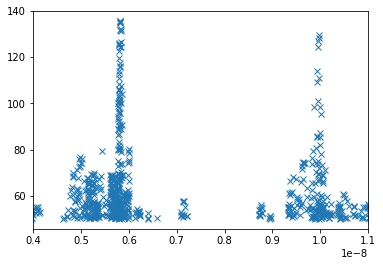

In [3]:
plt.plot(candidateLen,candidateLikely,'x')
plt.xlim([40e-10,110e-10])
plt.show()

In [89]:
l = 88 # |F|=115
delta_p = 6360110.611806864
x_real = l / (numBins * delta_p)
print("unit cell basis vector (real-space dimension): ", x_real) # 153.7 Angstroms

unit cell basis vector (real-space dimension):  1.537359705604236e-08


In [88]:
l = 47 # |F|=132
delta_p = 5173731.886272894
x_real = l / (numBins * delta_p)
print("unit cell basis vector (real-space dimension): ", x_real) # 100.9 Angstroms

unit cell basis vector (real-space dimension):  1.0093724098997057e-08


In [90]:
l = 38 # |F|=122
delta_p = 3640455.8933018413
x_real = l / (numBins * delta_p)
print("unit cell basis vector (real-space dimension): ", x_real) # 116.0 Angstroms

unit cell basis vector (real-space dimension):  1.159805899582738e-08


In [86]:
l = 44
delta_p = 3148313.544886684
x_real = l / (numBins * delta_p)
print("unit cell basis vector (real-space dimension): ", x_real) # 115.5 Angstroms

unit cell basis vector (real-space dimension):  1.5528595926632375e-08


In [87]:
l = 25 # |F|=132
delta_p = 4781751.791703285
x_real = l / (numBins * delta_p)
print("unit cell basis vector (real-space dimension): ", x_real) # 58 Angstroms

unit cell basis vector (real-space dimension):  5.809121633200286e-09


In [114]:
wavelen = 2*d*np.sin(theta)
1/d = 2*np.sin(theta)/wavelen
d = wavelen/(2*np.sin(theta)) # d is lattice spacing in metres



In [177]:
print(wavelength, pixSize, D)
thetaMax = np.arctan(22*pixSize/D)
qMax_crystal = 2/wavelength*np.sin(thetaMax/2)
#q=2/wavelength*np.sin(np.arctan(22*pixSize/D))
print(qMax_crystal, qMax_crystal/3600582.7923947247)
print(qMax_crystal/3861079.8187715053)

9.769292913385827e-11 0.00011 0.139
178191948.4096995 49.48975171077379
46.15080671043872


In [200]:
print(wavelength, D)
maxD = 100e-10 # maximum unit cell axis (m)
S = wavelength*D/maxD
print(S, pixSize)
nPixSearchRadius = S/pixSize
print("Search pixels on detector: ", nPixSearchRadius)

9.769292913385827e-11 0.139
0.0013579317149606301 0.00011
Search pixels on detector:  12.344833772369364


In [193]:
# S is search radius in metres
S = pixSize*24.68
a = wavelength*D/S
print(a)

5.0019585787558205e-09


In [204]:
binSize = 3861079.8187715053 # m^-1
#pos:  46
fRange = (numBins * binSize) # m^-1
FbinSize = 1/fRange # m
print(FbinSize)
Fpos = 46
realSpace= Fpos * FbinSize # m
print(realSpace)

2.1582908731435607e-10
4.964069008230189e-09


In [209]:
plt.xticks?